In [1]:
import numpy as np
import struct
import os

In [2]:
path = '/Users/precious/Desktop/Machine Learning/Neural Network(easy)/data'
kind = 'train'

labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind)
images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind)
with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II',lbpath.read(8))
    train_labels = np.fromfile(lbpath,dtype=np.uint8)
with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
    train_images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(train_labels), 784)

kind = 't10k'

labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind)
images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind)
with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II',lbpath.read(8))
    test_labels = np.fromfile(lbpath,dtype=np.uint8)
with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
    test_images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(test_labels), 784)  

plot figure

In [3]:
import matplotlib.pyplot as plt

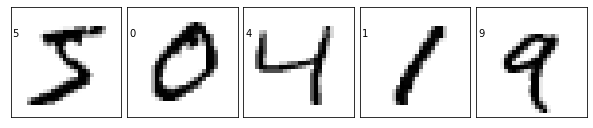

In [4]:
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for i in range(5):
    images = np.reshape(train_images[i], [28,28])
    ax=fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow(images,cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0,7,str(train_labels[i]))
plt.show()

In [5]:
import torch

dev = 'mps'

In [6]:
train_tensor = torch.tensor(train_images, dtype=torch.float)
test_tensor = torch.tensor(test_images, dtype=torch.float)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.int64)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.int64)

In [7]:
train_labels_tensor = torch.nn.functional.one_hot(train_labels_tensor, num_classes=10).float()
test_labels_tensor = torch.nn.functional.one_hot(test_labels_tensor, num_classes=10).float()

In [8]:
from torch.utils import data

def make_iters(tensor, labels, batch_size, num_workers=8):
    set = data.TensorDataset(tensor, labels)
    iter = data.DataLoader(set, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    return iter

In [9]:
batch_size = 100

# train_tensor = train_tensor[:1000]
# train_labels_tensor = train_labels_tensor[:1000]
# test_tensor = test_tensor[:100]
# test_labels_tensor = test_labels_tensor[:100]

train_iter = make_iters(train_tensor, train_labels_tensor, batch_size)
test_iter = make_iters(test_tensor, test_labels_tensor, batch_size)

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 280)
        self.predict = nn.Linear(280,10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.predict(x)
        return F.softmax(x, dim=0)

net = Net().to(dev)

In [11]:
input = torch.tensor(range(28*28),dtype=torch.float).to(dev)
out = net(input)
print(out)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9865e-01, 0.0000e+00, 2.0134e-01,
        4.6008e-06, 0.0000e+00, 0.0000e+00, 1.2845e-22], device='mps:0',
       grad_fn=<SoftmaxBackward0>)


/Users/precious/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::masked_select' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1664349113260/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1
                    #   , momentum=0.9
                      )

In [13]:
def evaluate_accuracy(net, data, data_labels):
    temp = net(data)
    temp = torch.max(temp, dim=1).indices
    return ((temp.eq(torch.max(data_labels, dim=1).indices)==True).sum() / len(data)).item()

evaluate_accuracy(net, test_tensor.to(dev), test_labels_tensor.to(dev))

0.17719998955726624

In [14]:
num_epochs = 50

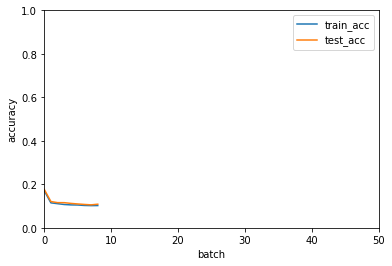

KeyboardInterrupt: 

In [15]:
from IPython import display


train_acc = evaluate_accuracy(net, train_tensor.to(dev), train_labels_tensor.to(dev))
test_acc = evaluate_accuracy(net, test_tensor.to(dev), test_labels_tensor.to(dev))

i = 0

y = np.array([[train_acc, test_acc]])
for epoch in range(num_epochs):
    running_loss = 0.0
    # i = 0
    for  batch_datas, batch_labels in train_iter:
        i += batch_size
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_datas.to(dev))
        loss = criterion(outputs, batch_labels.to(dev))
        # accumulation_steps = 10
        # loss = loss / accumulation_steps                # Normalize our loss (if averaged)
        # loss.backward()                                 # Backward pass
        # if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
        #     optimizer.step()                            # Now we can do an optimizer step
        #     net.zero_grad()                             # Reset gradients tensors
        #     if (i+1) % evaluation_steps == 0:           # Evaluate the model when we...
        #         criterion()                             # ...have no gradients accumulated
        loss.backward()
        optimizer.step()

        # print statistics
        # running_loss += loss.item()
        # if i % 30000 == 1:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / (2000/batch_size)))
        #     running_loss = 0.0
        # running_loss = loss.item()
    
    train_acc = evaluate_accuracy(net, train_tensor.to(dev), train_labels_tensor.to(dev))
    test_acc = evaluate_accuracy(net, test_tensor.to(dev), test_labels_tensor.to(dev))
    y = np.insert(y, len(y), np.array([train_acc, test_acc]), axis=0)	# 添加i的平方到y轴的数据中

    # print('train_accuracy={}'.format(evaluate_accuracy(net, train_iter)))
    print('test_accuracy={}'.format(test_acc))
    display.clear_output(wait=True)
    # print(y.shape)
    plt.plot(range(epoch+2), y[:,0], label='train_acc')
    plt.plot(range(epoch+2), y[:,1], label='test_acc')
    # plt.plot(y[:,2], label='loss')

    # plt.ylabel('accuracy')
    plt.xlim([0, num_epochs])
    plt.ylim([0,1])
    plt.xlabel('batch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    plt.pause(0.1)  # 暂停一段时间，不然画的太快会卡住显示不出来
    
    # print('train_accuracy={}'.format(evaluate_accuracy(net, train_iter)))
    # print('test_accuracy={}'.format(evaluate_accuracy(net, test_iter)))
    # animator.add(i + 1, train_metrics + (test_acc,))

# train_loss, train_acc = train_metrics

# plt.plot(accuracy_list)
# plt.ylabel('accuracy')
# plt.xlabel('epoch')